In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [5]:
res_1_df = pd.read_csv('1_1_polynomial_multiplication/results_1.1.csv')
res_2_df = pd.read_csv('1_2_shared_variable_update/results_1.2.csv')
res_3_df = pd.read_csv('1_3_array_analysis/results_1.3.csv')
res_4_df = pd.read_csv('1_4_bank_simulation/results_1.4.csv')
res_5_df = pd.read_csv('1_5_barrier_implementations/results_1.5.csv')

## Exercise 1.1: Polynomial Multiplication
Speedup and execution time analysis for polynomial multiplication with different degrees.

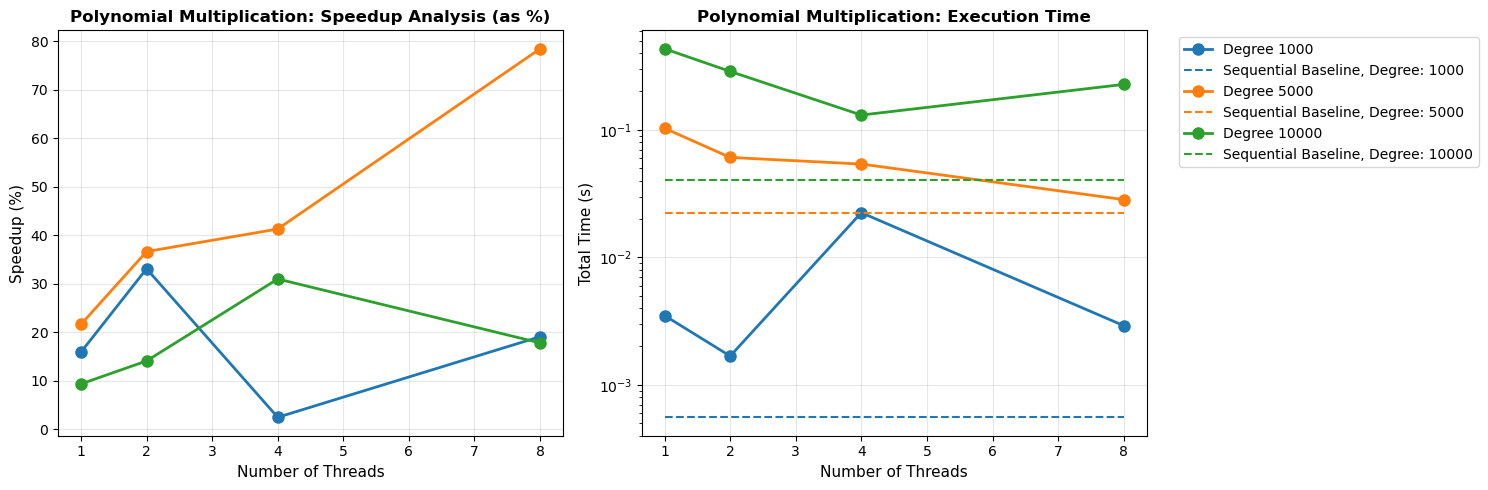

In [6]:
# 1.1 Polynomial Multiplication Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Sequential baselines by degree
seq_1_1 = res_1_df[res_1_df['threads'] == 'sequential'].groupby('degree')['time_total'].first()

for degree in sorted(res_1_df['degree'].unique()):
    degree_data = res_1_df[res_1_df['degree'] == degree]
    seq_time = seq_1_1[degree]
    
    parallel_data = degree_data[degree_data['threads'] != 'sequential'].copy()
    parallel_data['threads_num'] = parallel_data['threads'].astype(int)

    parallel_data['speedup_pct'] = 100.0 * (seq_time / parallel_data['time_total']) # percentage
    parallel_data = parallel_data.sort_values('threads_num')
    
    axes[0].plot(parallel_data['threads_num'], parallel_data['speedup_pct'], 
                    marker='o', linewidth=2, markersize=8, label=f'Degree {degree}')

axes[0].set_xlabel('Number of Threads', fontsize=11)
axes[0].set_ylabel('Speedup (%)', fontsize=11)
axes[0].set_title('Polynomial Multiplication: Speedup Analysis (as %)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Total execution time
for degree in sorted(res_1_df['degree'].unique()):
    degree_data = res_1_df[res_1_df['degree'] == degree]
    parallel_data = degree_data[degree_data['threads'] != 'sequential'].copy()
    parallel_data['threads_num'] = parallel_data['threads'].astype(int)
    parallel_data = parallel_data.sort_values('threads_num')
    
    line = axes[1].plot(parallel_data['threads_num'], parallel_data['time_total'], 
                    marker='o', linewidth=2, markersize=8, label=f'Degree {degree}')
    # add horizontal sequential baseline (straight line) using same color as the series
    seq_time = seq_1_1[degree]
    color = line[0].get_color()
    xmin = parallel_data['threads_num'].min()
    xmax = parallel_data['threads_num'].max()
    axes[1].hlines(seq_time, xmin=xmin, xmax=xmax, colors=color, linestyles='--', linewidth=1.5)
    # add baseline to legend (create an invisible line with same style/color)
    axes[1].plot([], [], color=color, linestyle='--', linewidth=1.5, label=f"Sequential Baseline, Degree: {degree}")

axes[1].set_xlabel('Number of Threads', fontsize=11)
axes[1].set_ylabel('Total Time (s)', fontsize=11)
axes[1].set_yscale('log')
axes[1].set_title('Polynomial Multiplication: Execution Time', fontsize=12, fontweight='bold')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Exercise 1.2: Shared Variable Update
Comparison of different synchronization methods (mutex, rwlock, atomic) for concurrent updates.

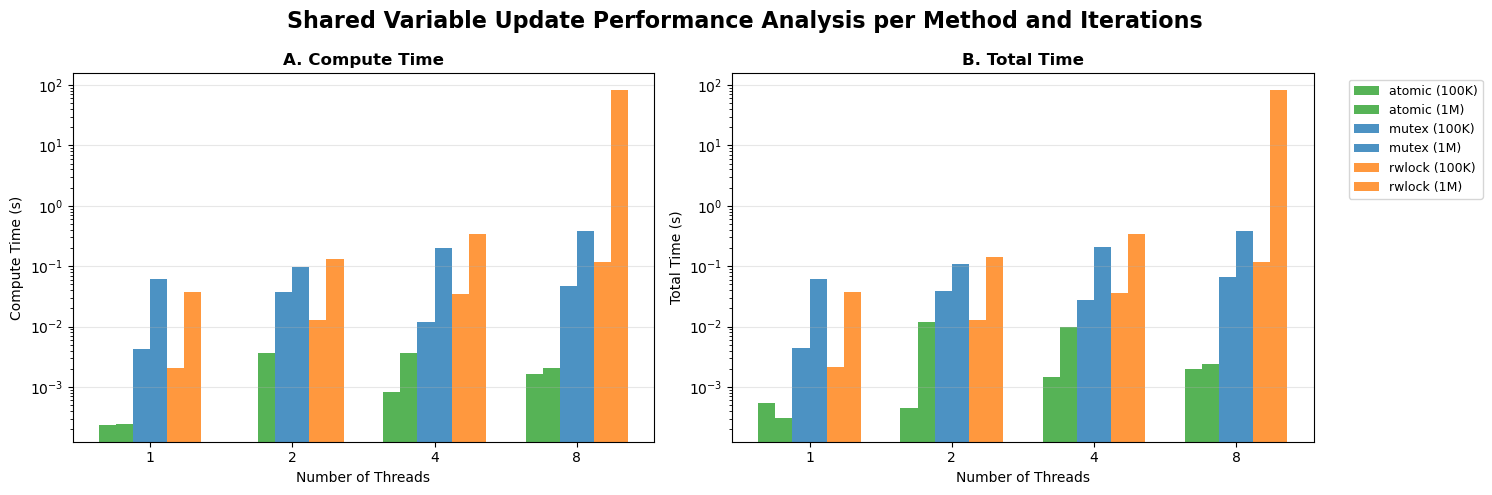

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 1.2 Shared Variable Update Analysis - Part 1 (A and B)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Shared Variable Update Performance Analysis per Method and Iterations', fontsize=16, fontweight='bold')

# Colors per method, markers per iteration
colors = {'mutex': '#1f77b4', 'rwlock': '#ff7f0e', 'atomic': '#2ca02c'}

# Helper function for iteration labels
def get_iter_label(iterations):
    if iterations >= 1000000:
        return f'{iterations//1000000}M'
    elif iterations >= 1000:
        return f'{iterations//1000}K'
    return str(iterations)

# Filter data
parallel_data = res_2_df[res_2_df['method'] != 'sequential'].copy()
parallel_data['threads_num'] = parallel_data['threads'].astype(int)

# Plot 1: Compute Time - Bar Plot
methods = sorted(parallel_data['method'].unique())
iterations_list = sorted(parallel_data['iterations'].unique())
threads_list = sorted(parallel_data['threads_num'].unique())

# Prepare data for Plot A (Compute Time)
x = np.arange(len(threads_list))
width = 0.12
bar_offset = 0

for method in methods:
    for iter_val in iterations_list:
        data = parallel_data[(parallel_data['method'] == method) & 
                            (parallel_data['iterations'] == iter_val)].sort_values('threads_num')
        label = f'{method} ({get_iter_label(iter_val)})'
        offset = (bar_offset - len(methods) * len(iterations_list) / 2 + 0.5) * width
        axes[0].bar(x + offset, data['time_compute'].values, width, label=label, alpha=0.8, color=colors[method])
        bar_offset += 1

axes[0].set_xlabel('Number of Threads')
axes[0].set_ylabel('Compute Time (s)')
axes[0].set_title('A. Compute Time', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(threads_list)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_yscale('log')

# Plot 2: Total Time - Bar Plot
x = np.arange(len(threads_list))
bar_offset = 0

for method in methods:
    for iter_val in iterations_list:
        data = parallel_data[(parallel_data['method'] == method) & 
                            (parallel_data['iterations'] == iter_val)].sort_values('threads_num')
        label = f'{method} ({get_iter_label(iter_val)})'
        offset = (bar_offset - len(methods) * len(iterations_list) / 2 + 0.5) * width
        axes[1].bar(x + offset, data['time_total'].values, width, label=label, alpha=0.8, color=colors[method])
        bar_offset += 1

axes[1].set_xlabel('Number of Threads')
axes[1].set_ylabel('Total Time (s)')
axes[1].set_title('B. Total Time', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(threads_list)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_yscale('log')

# Synchronize y-axis scales
y_min_a = axes[0].get_ylim()[0]
y_max_a = axes[0].get_ylim()[1]
y_min_b = axes[1].get_ylim()[0]
y_max_b = axes[1].get_ylim()[1]
y_min = min(y_min_a, y_min_b)
y_max = max(y_max_a, y_max_b)
axes[0].set_ylim([y_min, y_max])
axes[1].set_ylim([y_min, y_max])

plt.tight_layout()
plt.show()


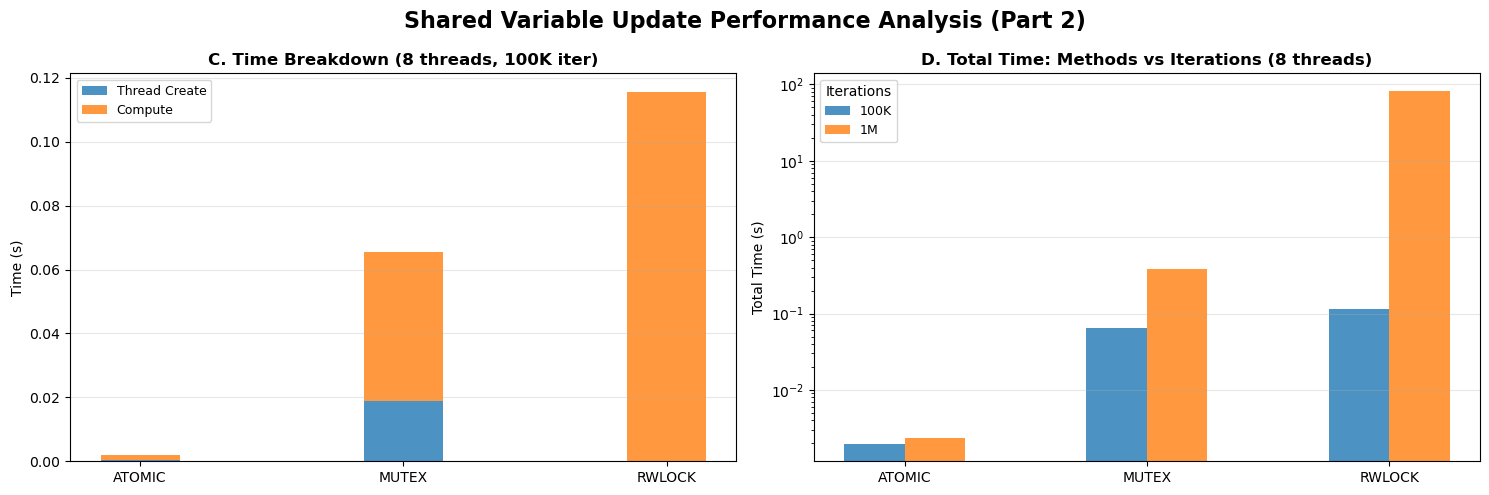

In [8]:
# 1.2 Shared Variable Update Analysis - Part 2 (C and D)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Shared Variable Update Performance Analysis (Part 2)', fontsize=16, fontweight='bold')

# Filter data
parallel_data = res_2_df[res_2_df['method'] != 'sequential'].copy()
parallel_data['threads_num'] = parallel_data['threads'].astype(int)

# Plot 3: Time Breakdown (8 threads, 100K iter)
eight_thread_100k = parallel_data[(parallel_data['threads_num'] == 8) & 
                                 (parallel_data['iterations'] == 100000)]

methods = sorted(eight_thread_100k['method'].unique())
components = ['time_thread_create', 'time_compute']
labels_breakdown = ['Thread Create', 'Compute']

x_pos = np.arange(len(methods))
bottom = np.zeros(len(methods))
bar_width = 0.3

for idx, component in enumerate(components):
    values = [eight_thread_100k[eight_thread_100k['method'] == m][component].values[0] for m in methods]
    axes[0].bar(x_pos, values, bottom=bottom, width=bar_width, label=labels_breakdown[idx], alpha=0.8)
    bottom += values

axes[0].set_ylabel('Time (s)')
axes[0].set_title('C. Time Breakdown (8 threads, 100K iter)', fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([m.upper() for m in methods])
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 4: Methods vs Iterations (8 threads)
eight_thread_all = parallel_data[parallel_data['threads_num'] == 8]
pivot_data = eight_thread_all.pivot_table(values='time_total', index='method', columns='iterations')

x_methods = np.arange(len(pivot_data.index))
width = 0.25
iterations_list = sorted(pivot_data.columns)

for idx, col in enumerate(iterations_list):
    offset = (idx - len(iterations_list)/2 + 0.5) * width
    axes[1].bar(x_methods + offset, pivot_data[col], width, 
                  label=get_iter_label(col), alpha=0.8)

axes[1].set_ylabel('Total Time (s)')
axes[1].set_title('D. Total Time: Methods vs Iterations (8 threads)', fontweight='bold')
axes[1].set_xticks(x_methods)
axes[1].set_xticklabels([m.upper() for m in pivot_data.index])
axes[1].legend(title='Iterations', fontsize=9)
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


# Exercise 1.3: Array Analysis
Performance comparison between sequential and parallel array processing for different array sizes.

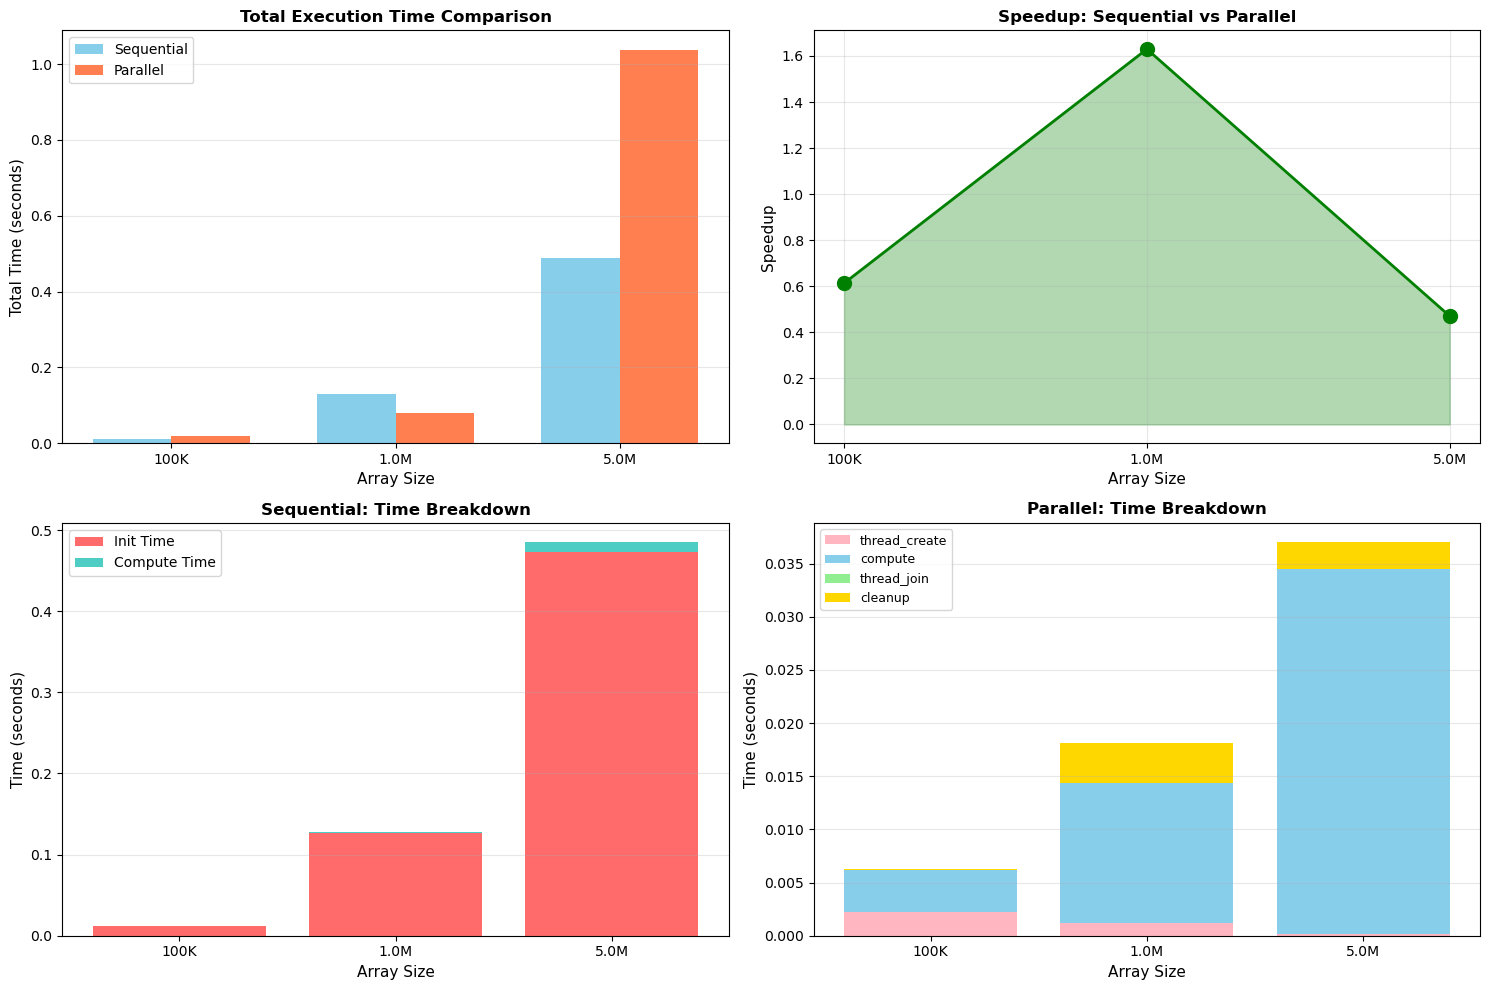

Array Analysis Summary:
  Size 100K: Speedup = 0.61x
  Size 1.0M: Speedup = 1.63x
  Size 5.0M: Speedup = 0.47x


In [9]:
# 1.3 Array Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sizes = sorted(res_3_df['size'].unique())

# Total execution time comparison
seq_times_3 = []
par_times_3 = []
size_labels = []

for size in sizes:
    size_data = res_3_df[res_3_df['size'] == size]
    seq_times_3.append(size_data[size_data['version'] == 'sequential']['time_total'].values[0])
    par_times_3.append(size_data[size_data['version'] == 'parallel']['time_total'].values[0])
    size_labels.append(f'{size/1e6:.1f}M' if size >= 1e6 else f'{size/1e3:.0f}K')

x_pos = np.arange(len(sizes))
width = 0.35

axes[0, 0].bar(x_pos - width/2, seq_times_3, width, label='Sequential', color='skyblue')
axes[0, 0].bar(x_pos + width/2, par_times_3, width, label='Parallel', color='coral')
axes[0, 0].set_xlabel('Array Size', fontsize=11)
axes[0, 0].set_ylabel('Total Time (seconds)', fontsize=11)
axes[0, 0].set_title('Total Execution Time Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(size_labels)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Speedup calculation
speedup_3 = np.array(seq_times_3) / np.array(par_times_3)
axes[0, 1].plot(range(len(sizes)), speedup_3, marker='o', linewidth=2, markersize=10, color='green')
axes[0, 1].fill_between(range(len(sizes)), speedup_3, alpha=0.3, color='green')
axes[0, 1].set_xlabel('Array Size', fontsize=11)
axes[0, 1].set_ylabel('Speedup', fontsize=11)
axes[0, 1].set_title('Speedup: Sequential vs Parallel', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(size_labels)
axes[0, 1].grid(True, alpha=0.3)

# Time breakdown for sequential
seq_breakdown = res_3_df[res_3_df['version'] == 'sequential'][['size', 'time_init', 'time_compute']].copy()
seq_breakdown = seq_breakdown.sort_values('size')

axes[1, 0].bar(range(len(seq_breakdown)), seq_breakdown['time_init'], label='Init Time', color='#FF6B6B')
axes[1, 0].bar(range(len(seq_breakdown)), seq_breakdown['time_compute'], 
              bottom=seq_breakdown['time_init'], label='Compute Time', color='#4ECDC4')
axes[1, 0].set_xlabel('Array Size', fontsize=11)
axes[1, 0].set_ylabel('Time (seconds)', fontsize=11)
axes[1, 0].set_title('Sequential: Time Breakdown', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(size_labels)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Time breakdown for parallel
par_breakdown = res_3_df[res_3_df['version'] == 'parallel'][['size', 'time_thread_create', 'time_compute', 'time_thread_join', 'time_cleanup']].copy()
par_breakdown = par_breakdown.sort_values('size')

bottom_par = np.zeros(len(par_breakdown))
colors_par = ['#FFB6C1', '#87CEEB', '#90EE90', '#FFD700']
components = ['time_thread_create', 'time_compute', 'time_thread_join', 'time_cleanup']

for idx, comp in enumerate(components):
    axes[1, 1].bar(range(len(par_breakdown)), par_breakdown[comp], bottom=bottom_par, 
                  label=comp.replace('time_', ''), color=colors_par[idx])
    bottom_par += par_breakdown[comp].values

axes[1, 1].set_xlabel('Array Size', fontsize=11)
axes[1, 1].set_ylabel('Time (seconds)', fontsize=11)
axes[1, 1].set_title('Parallel: Time Breakdown', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(size_labels)
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Array Analysis Summary:")
for i, size in enumerate(sizes):
    print(f"  Size {size_labels[i]}: Speedup = {speedup_3[i]:.2f}x")

# Exercise 1.4: Bank Simulation
Analysis of different locking schemes with varying query percentages and account counts.

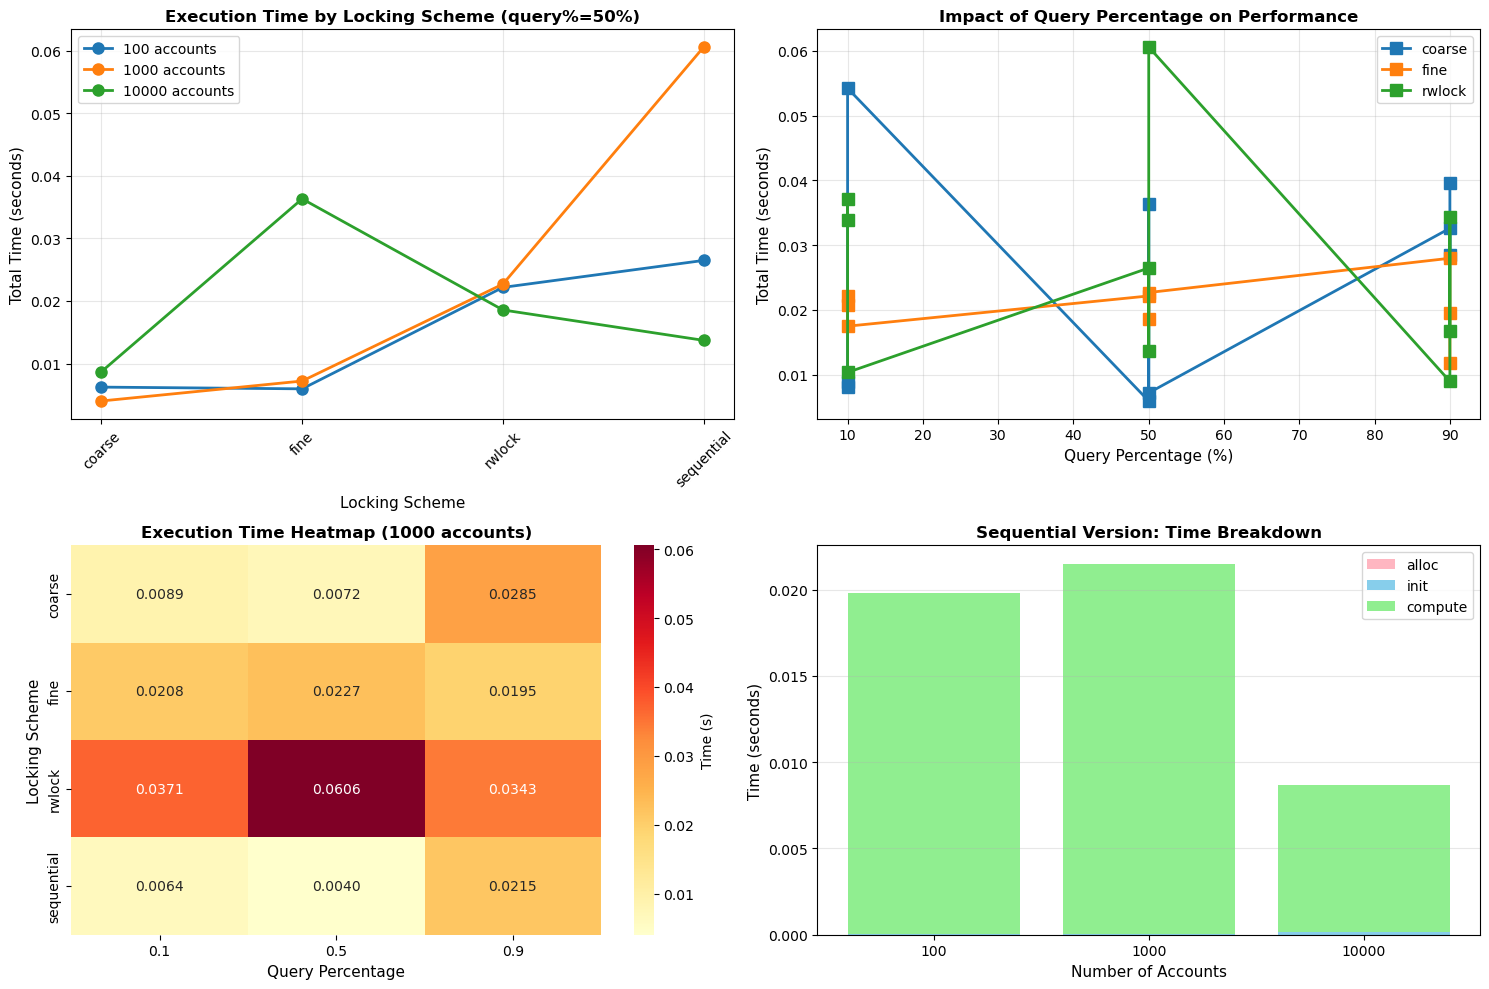

Bank Simulation Summary:
  Sequential baseline: 0.004022s
  Locking schemes tested: coarse, fine, rwlock, sequential


In [10]:
# 1.4 Bank Simulation Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

locking_schemes = sorted(res_4_df['locking_scheme'].unique())
accounts_list = sorted(res_4_df['accounts'].unique())
query_pcts = sorted(res_4_df['query_pct'].unique())

# Performance by locking scheme and accounts (query_pct = 0.5)
mid_query = 0.5
for accounts in accounts_list[:3]:  # Show 3 account sizes
    data_subset = res_4_df[(res_4_df['accounts'] == accounts) & (res_4_df['query_pct'] == mid_query)]
    axes[0, 0].plot(range(len(data_subset)), data_subset['time_total'], 
                   marker='o', linewidth=2, markersize=8, label=f'{accounts} accounts')

axes[0, 0].set_xlabel('Locking Scheme', fontsize=11)
axes[0, 0].set_ylabel('Total Time (seconds)', fontsize=11)
axes[0, 0].set_title(f'Execution Time by Locking Scheme (query%={mid_query*100:.0f}%)', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(range(len(locking_schemes)))
axes[0, 0].set_xticklabels(locking_schemes, rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Impact of query percentage
for scheme in locking_schemes[:3]:  # Show 3 schemes
    scheme_data = res_4_df[res_4_df['locking_scheme'] == scheme].copy()
    scheme_data = scheme_data.sort_values('query_pct')
    axes[0, 1].plot(scheme_data['query_pct'] * 100, scheme_data['time_total'], 
                   marker='s', linewidth=2, markersize=8, label=scheme)

axes[0, 1].set_xlabel('Query Percentage (%)', fontsize=11)
axes[0, 1].set_ylabel('Total Time (seconds)', fontsize=11)
axes[0, 1].set_title('Impact of Query Percentage on Performance', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Heatmap: locking scheme vs query percentage for fixed accounts
heatmap_data = res_4_df[res_4_df['accounts'] == accounts_list[1]].pivot_table(
    values='time_total', index='locking_scheme', columns='query_pct')

sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='YlOrRd', ax=axes[1, 0], cbar_kws={'label': 'Time (s)'})
axes[1, 0].set_title(f'Execution Time Heatmap ({accounts_list[1]} accounts)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Locking Scheme', fontsize=11)
axes[1, 0].set_xlabel('Query Percentage', fontsize=11)

# Time breakdown for sequential
seq_data = res_4_df[res_4_df['locking_scheme'] == 'sequential'].copy()
seq_data = seq_data.sort_values('accounts')

time_comps_4 = ['time_alloc', 'time_init', 'time_compute', 'time_thread_create', 'time_thread_join']
colors_4 = ['#FFB6C1', '#87CEEB', '#90EE90', '#FFD700', '#DDA0DD']

bottom_4 = np.zeros(len(seq_data))
for idx, comp in enumerate(time_comps_4[:3]):  # Show top 3
    axes[1, 1].bar(seq_data['accounts'].astype(str), seq_data[comp], 
                  bottom=bottom_4, label=comp.replace('time_', ''), color=colors_4[idx])
    bottom_4 += seq_data[comp].values

axes[1, 1].set_xlabel('Number of Accounts', fontsize=11)
axes[1, 1].set_ylabel('Time (seconds)', fontsize=11)
axes[1, 1].set_title('Sequential Version: Time Breakdown', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Bank Simulation Summary:")
seq_min = res_4_df[res_4_df['locking_scheme']=='sequential']['time_total'].min()
print(f"  Sequential baseline: {seq_min:.6f}s")
print(f"  Locking schemes tested: {', '.join(locking_schemes)}")

# Exercise 1.5: Barrier Implementations
Performance comparison of different barrier synchronization techniques (pthread, condition variable, sense reversal).

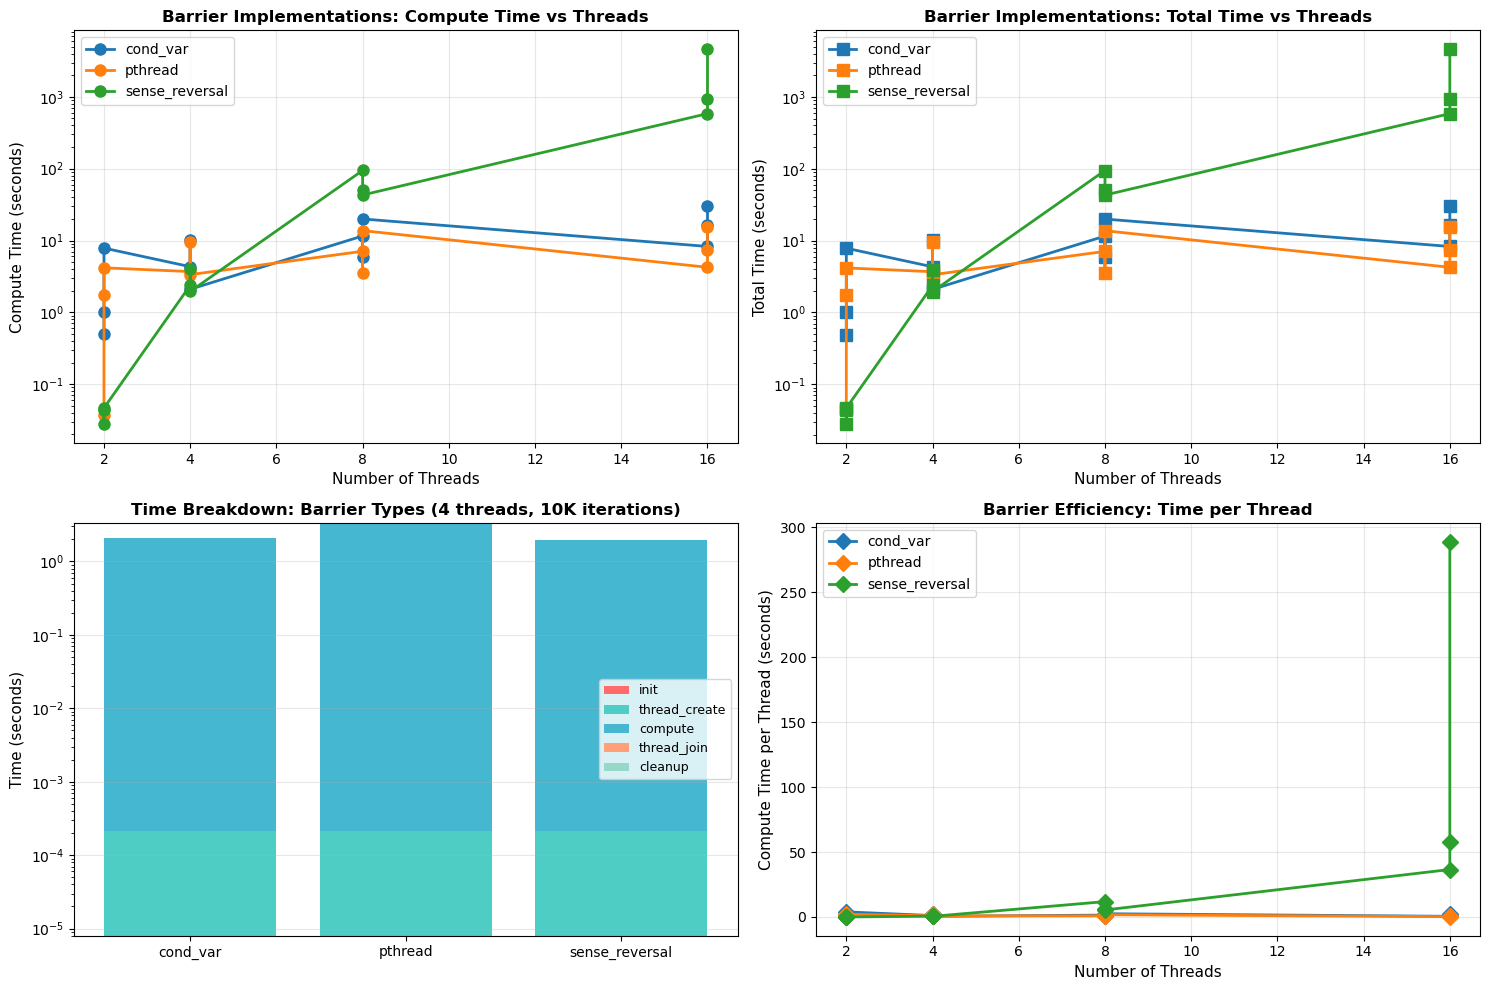

Barrier Implementations Summary:
  cond_var: Best config - 2 threads, 0.492985s
  pthread: Best config - 2 threads, 0.045593s
  sense_reversal: Best config - 2 threads, 0.027672s


In [11]:
# 1.5 Barrier Implementations Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

barrier_types = sorted(res_5_df['barrier_type'].unique())
iterations_list = sorted(res_5_df['iterations'].unique())
threads_list = sorted(res_5_df['threads'].unique())

# Compute time vs thread count
for barrier in barrier_types:
    barrier_data = res_5_df[res_5_df['barrier_type'] == barrier].copy()
    barrier_data = barrier_data.sort_values('threads')
    axes[0, 0].plot(barrier_data['threads'], barrier_data['time_compute'], 
                   marker='o', linewidth=2, markersize=8, label=barrier)

axes[0, 0].set_xlabel('Number of Threads', fontsize=11)
axes[0, 0].set_ylabel('Compute Time (seconds)', fontsize=11)
axes[0, 0].set_title('Barrier Implementations: Compute Time vs Threads', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_yscale('log')

# Total time comparison
for barrier in barrier_types:
    barrier_data = res_5_df[res_5_df['barrier_type'] == barrier].copy()
    barrier_data = barrier_data.sort_values('threads')
    axes[0, 1].plot(barrier_data['threads'], barrier_data['time_total'], 
                   marker='s', linewidth=2, markersize=8, label=barrier)

axes[0, 1].set_xlabel('Number of Threads', fontsize=11)
axes[0, 1].set_ylabel('Total Time (seconds)', fontsize=11)
axes[0, 1].set_title('Barrier Implementations: Total Time vs Threads', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_yscale('log')

# Time breakdown for 4 threads
four_thread_data = res_5_df[res_5_df['threads'] == 4]
time_comps_5 = ['time_init', 'time_thread_create', 'time_compute', 'time_thread_join', 'time_cleanup']
colors_5 = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

x_pos_5 = np.arange(len(barrier_types))
bottom_5 = np.zeros(len(barrier_types))

for idx, comp in enumerate(time_comps_5):
    values = [four_thread_data[four_thread_data['barrier_type'] == b][comp].values[0] 
              for b in barrier_types]
    axes[1, 0].bar(x_pos_5, values, bottom=bottom_5, label=comp.replace('time_', ''), color=colors_5[idx])
    bottom_5 += np.array(values)

axes[1, 0].set_ylabel('Time (seconds)', fontsize=11)
axes[1, 0].set_title('Time Breakdown: Barrier Types (4 threads, 10K iterations)', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x_pos_5)
axes[1, 0].set_xticklabels(barrier_types)
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_yscale('log')

# Efficiency: compute time per thread
efficiency_data = []
for barrier in barrier_types:
    barrier_data = res_5_df[res_5_df['barrier_type'] == barrier].copy()
    barrier_data = barrier_data.sort_values('threads')
    barrier_data['efficiency'] = barrier_data['time_compute'] / barrier_data['threads']
    efficiency_data.append(barrier_data)

for barrier, data in zip(barrier_types, efficiency_data):
    axes[1, 1].plot(data['threads'], data['efficiency'], 
                   marker='D', linewidth=2, markersize=8, label=barrier)

axes[1, 1].set_xlabel('Number of Threads', fontsize=11)
axes[1, 1].set_ylabel('Compute Time per Thread (seconds)', fontsize=11)
axes[1, 1].set_title('Barrier Efficiency: Time per Thread', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Barrier Implementations Summary:")
for barrier in barrier_types:
    best_config = res_5_df[res_5_df['barrier_type'] == barrier].nsmallest(1, 'time_total')
    print(f"  {barrier}: Best config - {best_config['threads'].values[0]} threads, {best_config['time_total'].values[0]:.6f}s")